In [55]:
#|default_exp accel

# Denoising Diffusion Probabilistic Models with miniai

## Imports

In [1]:
!git clone https://github.com/ubermenchh/my_fastai_part2.git

Cloning into 'my_fastai_part2'...
remote: Enumerating objects: 159, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 159 (delta 6), reused 12 (delta 3), pack-reused 139
Receiving objects: 100% (159/159), 118.17 MiB | 24.06 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [2]:
%cd my_fastai_part2
!ls

/kaggle/working/my_fastai_part2
LICENSE  README.md  miniai  nbs  settings.ini  test


In [3]:
!pip -q install torcheval datasets

In [56]:
#|export
import pickle, gzip, math, os, time, shutil, torch, random, logging
import fastcore.all as fc, matplotlib as mpl, numpy as np, matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF, torch.nn.functional as F
from torch import tensor, nn, optim
from torch.utils.data import DataLoader, default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

In [5]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset, load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

## Load the Dataset

In [6]:
xl, yl = 'image', 'label'
name = 'fashion_mnist'
dsd = load_dataset(name)

@inplace
def transformi(b):
    b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2)) for o in b[xl]]
    
bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
dt = dls.train
xb, yb = next(iter(dt))

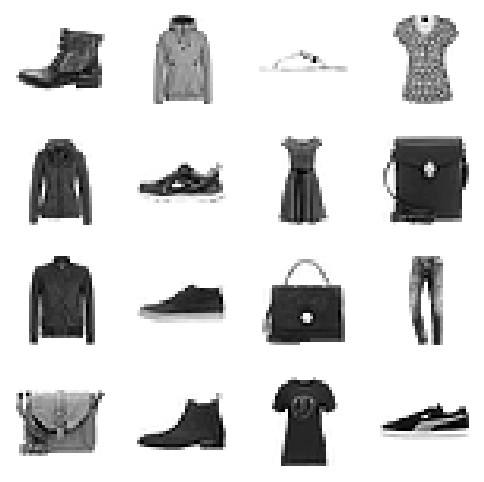

In [8]:
show_images(xb[:16], imsize=1.5)

In [9]:
betamin, betamax, n_steps = 0.0001, 0.02, 1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1. - beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

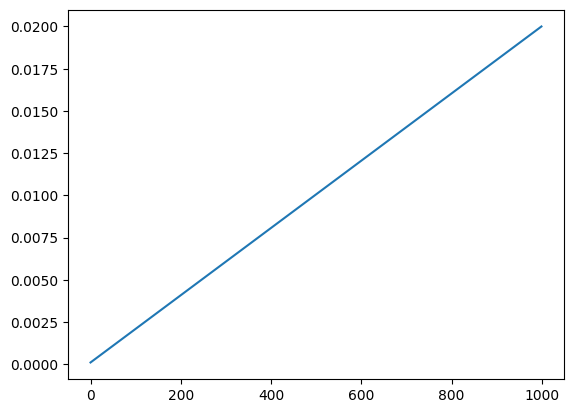

In [10]:
plt.plot(beta);

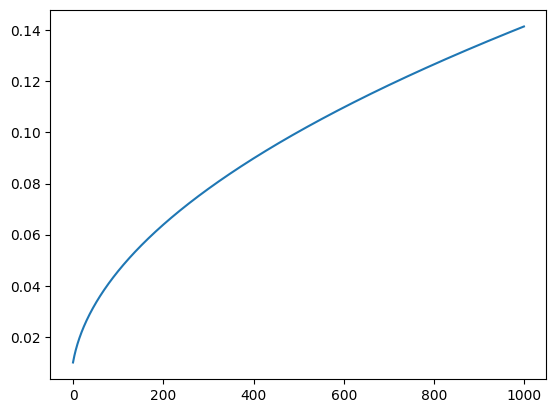

In [11]:
plt.plot(sigma);

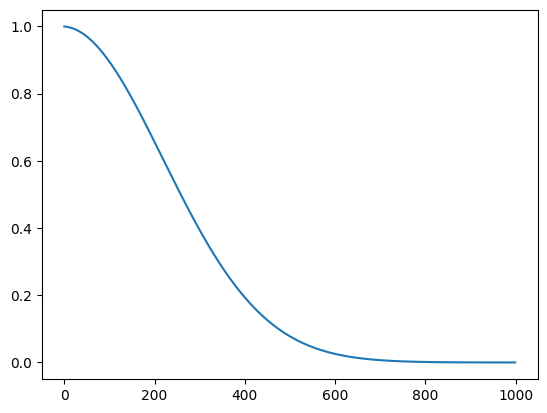

In [12]:
plt.plot(alphabar);

In [13]:
def noisify(x0, alpha):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    epsilon = torch.randn(x0.shape, device=device)
    alpha_t = alpha[t].reshape(-1, 1, 1, 1).to(device)
    xt = alpha_t.sqrt()*x0 + (1 - alpha_t).sqrt() * epsilon
    return (xt, t.to(device)), epsilon

In [14]:
(xt, t), epsilon = noisify(xb[:25], alphabar)
t

tensor([519, 189,  88, 983, 256, 274, 486, 516, 267, 259, 816, 966, 203, 132,
        150, 403,  58, 230, 194, 204, 940, 892, 712, 803, 434])

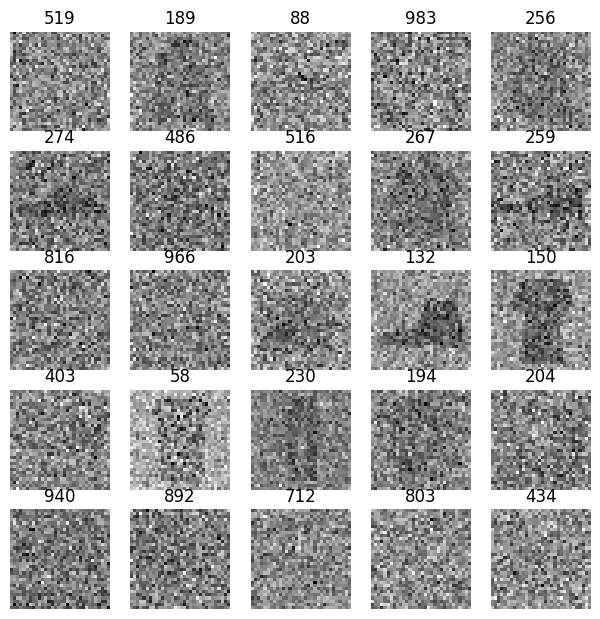

In [15]:
titles = fc.map_ex(t, '{}')
show_images(xt, imsize=1.5, titles=titles)

In [16]:
!pip install diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 41.3 MB/s eta 0:00:0000:01


In [17]:
from diffusers import UNet2DModel

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [18]:
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
        alpha_t1 = alphabar[t-1] if t > 0 else torch.tensor(1)
        beta_t = 1 - alphabar[t]
        beta_t1 = 1 - alpha_t1
        x_0_hat = ((x_t - beta_t.sqrt() * learn.model((x_t, t_batch))) / alphabar[t].sqrt()).clamp(-1, 1)
        x_t = x_0_hat * alpha_t1.sqrt() * (1 - alpha[t]) / beta_t + x_t * alpha[t].sqrt() * beta_t1 / beta_t + sigma[t] * z
        preds.append(x_t.cpu())
    return preds

In [19]:
class DDPMCB(Callback):
    order = DeviceCB.order + 1
    def __init__(self, n_steps, beta_min, beta_max):
        super().__init__()
        fc.store_attr()
        self.beta = torch.linspace(self.beta_min, self.beta_max, self.n_steps)
        self.alpha = 1. - self.beta
        self.alphabar = torch.cumprod(self.alpha, dim=0)
        self.sigma = self.beta.sqrt()
        
    def before_batch(self, learn): 
        learn.batch = noisify(learn.batch[0], self.alphabar)
    
    def sample(self, model, sz):
        return sample(model, sz, self.alpha, self.alphabar, self.sigma, self.n_steps)

In [20]:
class UNet(UNet2DModel):
    def forward(self, x):
        return super().forward(*x).sample

In [21]:
ddpm_cb = DDPMCB(n_steps=1000, beta_min=0.0001, beta_max=0.02)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


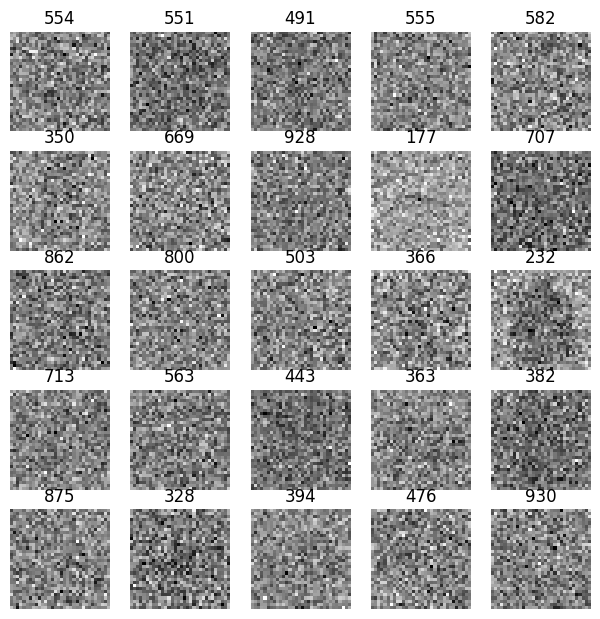

In [22]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 64), norm_num_groups=8)

learn = TrainLearner(model, dls, nn.MSELoss())
learn.fit(train=False, cbs=[ddpm_cb, SingleBatchCB()])
(xt, t), epsilon = learn.batch
show_images(xt[:25], titles=fc.map_ex(t[:25], '{}'), imsize=1.5)

In [23]:
lr = 5e-3
epochs = 5

tmax = epochs * len(dls.train) 
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]

In [24]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)

In [25]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers):
                init.orthogonal_(p.conv.weight)
    
    for o in model.up_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
    
    model.conv_out.weight.data.zero_()

In [26]:
init_ddpm(model)

In [27]:
opt_func = partial(optim.Adam, eps=1e-5)
learn = TrainLearner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.147,0,train
0.024,0,eval
0.023,1,train
0.020,1,eval
0.021,2,train
0.019,2,eval
0.019,3,train
0.019,3,eval
0.018,4,train
0.018,4,eval


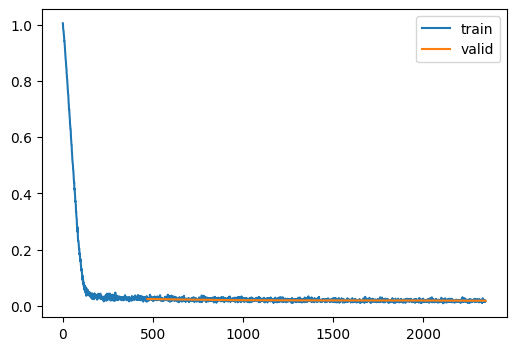

In [28]:
learn.fit(epochs)

In [29]:
mdl_path = Path('/kaggle/working/my_fastai_part2/nbs/models')
torch.save(learn.model, mdl_path/'fashion_ddpm2.pkl')

In [30]:
learn.model = torch.load(mdl_path/'fashion_ddpm2.pkl')

## Sampling

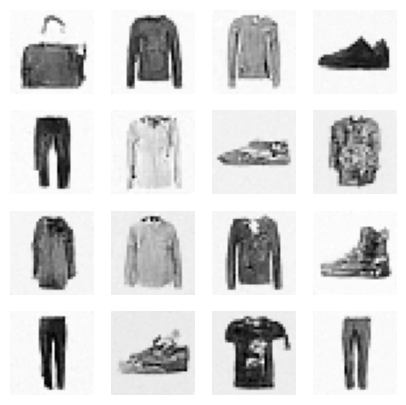

In [31]:
samples = ddpm_cb.sample(learn.model, (16, 1, 32, 32))
show_images(samples[-1], figsize=(5, 5))

## Mixed Precision

In [32]:
bs = 512

In [33]:
next(iter(DataLoader(tds['train'], batch_size=2)))

{'image': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]),
 'label': tensor([9, 0])}

In [34]:
def collate_ddpm(b):
    return noisify(default_collate(b)[xl], alphabar)

In [35]:
def dl_ddpm(ds):
    return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=4)

In [37]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [57]:
#|export
class MixedPrecision(TrainCB):
    order = DeviceCB.order + 10
    
    def before_fit(self, learn):
        self.scaler = torch.cuda.amp.GradScaler()
    
    def before_batch(self, learn):
        self.autocast = torch.autocast('cuda', dtype=torch.float16)
        self.autocast.__enter__()
        
    def after_loss(self, learn):
        self.autocast.__exit__(None, None, None)
        
    def backward(self, learn):
        self.scaler.scale(learn.loss).backward()
    
    def step(self, learn):
        self.scaler.step(learn.opt)
        self.scaler.update()

In [43]:
lr = 1e-2
epochs = 8
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.263,0,train
0.032,0,eval
0.029,1,train
0.028,1,eval
0.024,2,train
0.024,2,eval
0.021,3,train
0.020,3,eval
0.020,4,train
0.020,4,eval


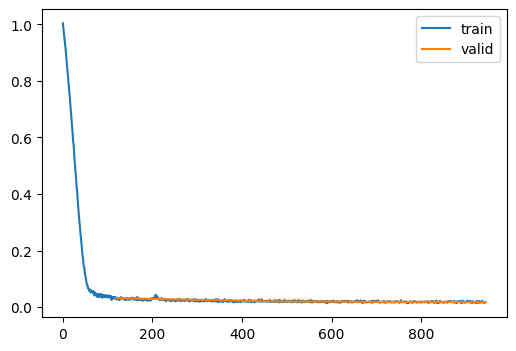

In [44]:
learn.fit(epochs)

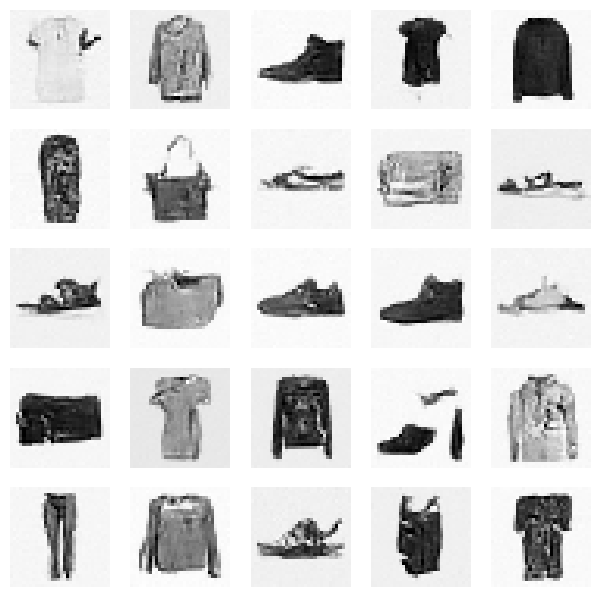

In [45]:
samples = sample(learn.model, (32, 1, 32, 32), alpha, alphabar, sigma, n_steps)
show_images(samples[-1][:25], imsize=1.5)

In [46]:
torch.save(learn.model, '/kaggle/working/my_fastai_part2/nbs/models/fashion_ddpm_mp.pkl')

## Accelerate

In [58]:
#|export
from accelerate import Accelerator

In [59]:
#|export
class AccelerateCB(TrainCB):
    order = DeviceCB.order + 10
    
    def __init__(self, n_inp=1, mixed_precision='fp16'):
        super().__init__(n_inp=n_inp)
        self.acc = Accelerator(mixed_precision=mixed_precision)
        
    def before_fit(self, learn):
        learn.model, learn.opt, learn.dls.train, learn.dls.valid = self.acc.prepare(learn.model, learn.opt, learn.dls.train, learn.dls.valid)
    
    def backward(self, learn):
        self.acc.backward(learn.loss)

In [50]:
def noisify(x0, alphabar):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    epsilon = torch.randn(x0.shape, device=device)
    alphabar_t = alphabar[t].reshape(-1, 1, 1, 1).to(device)
    xt = alphabar_t.sqrt() * x0 + (1 - alphabar_t).sqrt() * epsilon
    return xt, t.to(device), epsilon

In [51]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [52]:
class DDPMCB2(Callback):
    def after_predict(self, learn):
        learn.preds = learn.preds.sample

In [53]:
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)
init_ddpm(model)
cbs = [DDPMCB2(), DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), AccelerateCB(n_inp=2)]
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.267,0,train
0.032,0,eval
0.028,1,train
0.025,1,eval
nan,2,train
inf,2,eval
nan,3,train
inf,3,eval
nan,4,train
inf,4,eval


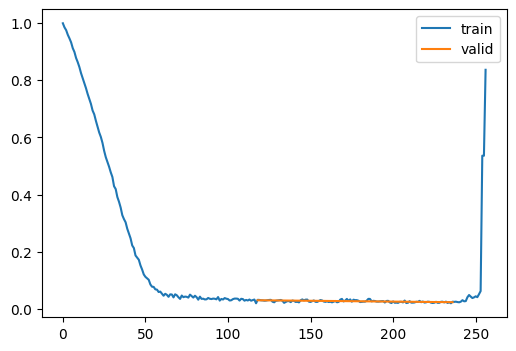

In [54]:
learn.fit(epochs)

## Export -

In [1]:
import nbdev; nbdev.nbdev_export()